In [ ]:
#Sim function that returns tuple df, x, y instear of df

In [22]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf
import os

In [23]:
def generate_data(T, alpha, beta, sigma, alpha_y, beta_y, gamma, theta, sigma_y, mu):
    df = pd.DataFrame(index=range(T), columns=['x', 'y', 'epsilon_x', 'epsilon_y'])
    x1 = alpha/(1-beta) # define initial value for time series x
    y1 = 0
    epsilon_x = sigma*np.random.randn(T) + mu # generate a vector of T random normal
    epsilon_y = sigma_y*np.random.randn(T) # generate a vector of T random normal
    
    df.iloc[0,:] = [x1, y1, np.nan, np.nan] # initialize x and y
    
    x = np.zeros(T)
    y = np.zeros(T)
    x[0] = x1
    y[0] = y1
    
    for i in range(0, T-1):
        x[i+1] = alpha + beta * x[i] + epsilon_x[i+1] # generate X(t) recursively
            # Xt = α + βXt-1 + εt
        y[i+1] = alpha_y + beta_y * y[i] + gamma * x[i+1] + epsilon_y[i+1] + theta * epsilon_y[i] # generate Y(t) recursively
            # Yt = α + βYt-1 + γXt + εt + θεt-1
        df.iloc[i+1,0] = x[i+1]
        df.iloc[i+1,1] = y[i+1]
        df.iloc[i+1,2] = epsilon_x[i+1] # associate error with X(t)
        df.iloc[i+1,3] = epsilon_y[i+1] # associate error with Y(t)
    
    return df, x, y, epsilon_x, epsilon_y

In [24]:
#1000, 1, 0.9, 3, 6, 0.3, 0.9, 0.9, 8, 1.7
#1000, 1, 0.9, 0.1, 1, 0.9, 0.9, 0.5, 0.1, 0

df, x, y, epsilon_x, epsilon_y = generate_data(1000, 1, 0.9, 3, 6, 0.3, 0.9, 0.9, 8, 1.7)
new_df = df.drop(0)

In [25]:
''' Modified '''
################################ Quantile linear regression with package ################################
def fit_quantile2(df):
    # Fit quantile regression at the specified quantile
    y = df['y'].values.astype(float)
    x = df['x'].values.astype(float)
    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    
    quant_reg_1 = sm.QuantReg(y, y_lag + x).fit(q=0.1)
    quant_reg_5 = sm.QuantReg(y, y_lag + x).fit(q=0.5)
    quant_reg_9 = sm.QuantReg(y, y_lag + x).fit(q=0.9)
    # Yt = α + βYt-1 + γXt 

# Plot the quantile regression lines at different quantile levels
    # Create a scatter plot of the data
    plt.scatter(x, y, alpha=0.5)
    x_sort = np.sort(x)
    y_pred_1 = quant_reg_1.predict(x_sort)
    y_pred_5 = quant_reg_5.predict(x_sort)
    y_pred_9 = quant_reg_9.predict(x_sort)

    plt.plot(x_sort, y_pred_1, color='red', label='Quantile level: 0.1')
    plt.plot(x_sort, y_pred_5, color='green', label='Quantile level: 0.5')
    plt.plot(x_sort, y_pred_9, color='blue', label='Quantile level: 0.9')

    # Add a legend and labels to the plot
    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Quantile regression at different quantile levels')
    plt.show()

    ################################ Autocorrelation of the residuals ##############################
    residuals_1 = quant_reg_1.resid # Calculate the residuals
    residuals_5 = quant_reg_5.resid # Calculate the residuals
    residuals_9 = quant_reg_9.resid # Calculate the residuals

    # Plot the autocorrelation function of the residuals for all three quantile regression models in one plot
    fig, ax = plt.subplots(3, 1, figsize=(8, 10))
    plot_acf(quant_reg_1.resid, ax=ax[0])
    ax[0].set_title('Autocorrelation of residuals (quantile level = 0.1)')
    plot_acf(quant_reg_5.resid, ax=ax[1])
    ax[1].set_title('Autocorrelation of residuals (quantile level = 0.5)')
    plot_acf(quant_reg_9.resid, ax=ax[2])
    ax[2].set_title('Autocorrelation of residuals (quantile level = 0.9)')
    plt.tight_layout()
    plt.show()


    return quant_reg_1.summary(), quant_reg_5.summary(), quant_reg_9.summary()


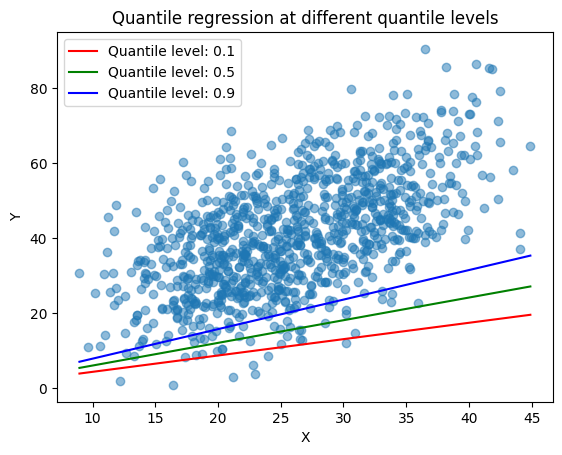

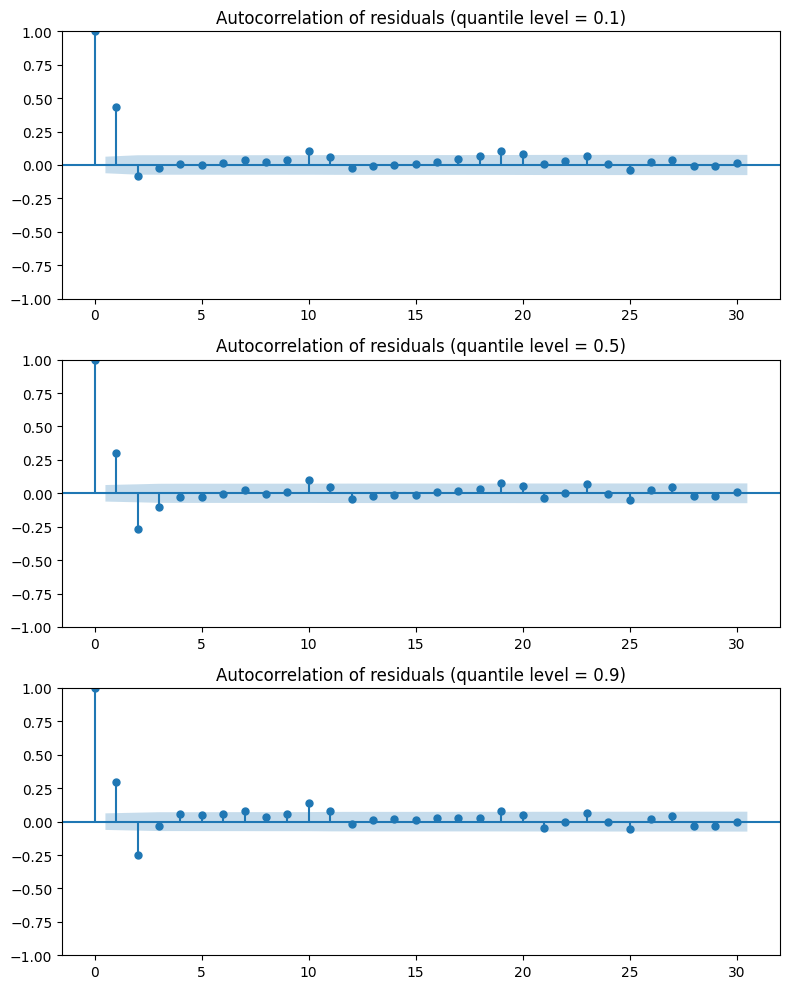

(<class 'statsmodels.iolib.summary.Summary'>
 """
                          QuantReg Regression Results                          
 Dep. Variable:                      y   Pseudo R-squared:               0.3285
 Model:                       QuantReg   Bandwidth:                       4.132
 Method:                 Least Squares   Sparsity:                        45.93
 Date:                Wed, 26 Apr 2023   No. Observations:                  999
 Time:                        19:34:38   Df Residuals:                      998
                                         Df Model:                            1
                  coef    std err          t      P>|t|      [0.025      0.975]
 ------------------------------------------------------------------------------
 x1             0.4363      0.006     73.852      0.000       0.425       0.448
 """,
 <class 'statsmodels.iolib.summary.Summary'>
 """
                          QuantReg Regression Results                          
 Dep. Variable

In [26]:
fit_quantile2(new_df)

In [27]:
################################ Quantile linear regression with package ################################
def fit_quantile(df, alpha_y, beta_y, gamma):
    # Fit quantile regression at the specified quantile
    y = df['y'].values.astype(float)
    x = df['x'].values.astype(float)
    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    
    quant_reg_1 = sm.QuantReg(y, alpha_y + beta_y * y_lag + gamma * x).fit(q=0.1)
    quant_reg_5 = sm.QuantReg(y, alpha_y + beta_y * y_lag + gamma * x).fit(q=0.5)
    quant_reg_9 = sm.QuantReg(y, alpha_y + beta_y * y_lag + gamma * x).fit(q=0.9)
    # Yt = α + βYt-1 + γXt 

# Plot the quantile regression lines at different quantile levels
    # Create a scatter plot of the data
    plt.scatter(x, y, alpha=0.5)
    x_sort = np.sort(x)
    y_pred_1 = quant_reg_1.predict(x_sort)
    y_pred_5 = quant_reg_5.predict(x_sort)
    y_pred_9 = quant_reg_9.predict(x_sort)

    plt.plot(x_sort, y_pred_1, color='red', label='Quantile level: 0.1')
    plt.plot(x_sort, y_pred_5, color='green', label='Quantile level: 0.5')
    plt.plot(x_sort, y_pred_9, color='blue', label='Quantile level: 0.9')

    # Add a legend and labels to the plot
    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Quantile regression at different quantile levels')
    plt.show()

    ################################ Autocorrelation of the residuals ##############################
    residuals_1 = quant_reg_1.resid # Calculate the residuals
    residuals_5 = quant_reg_5.resid # Calculate the residuals
    residuals_9 = quant_reg_9.resid # Calculate the residuals

    # Plot the autocorrelation function of the residuals for all three quantile regression models in one plot
    fig, ax = plt.subplots(3, 1, figsize=(8, 10))
    plot_acf(quant_reg_1.resid, ax=ax[0])
    ax[0].set_title('Autocorrelation of residuals (quantile level = 0.1)')
    plot_acf(quant_reg_5.resid, ax=ax[1])
    ax[1].set_title('Autocorrelation of residuals (quantile level = 0.5)')
    plot_acf(quant_reg_9.resid, ax=ax[2])
    ax[2].set_title('Autocorrelation of residuals (quantile level = 0.9)')
    plt.tight_layout()
    plt.show()


    return quant_reg_1.summary(), quant_reg_5.summary(), quant_reg_9.summary()

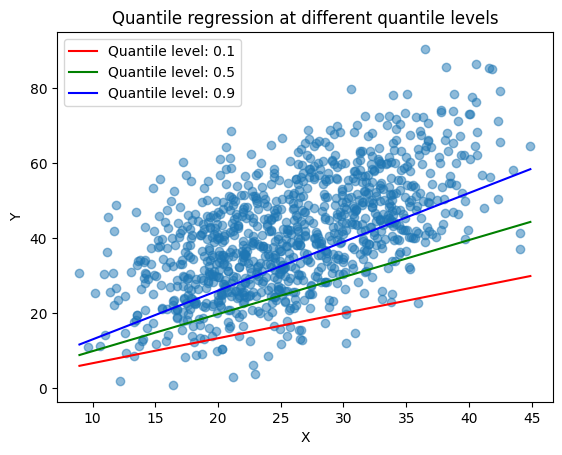

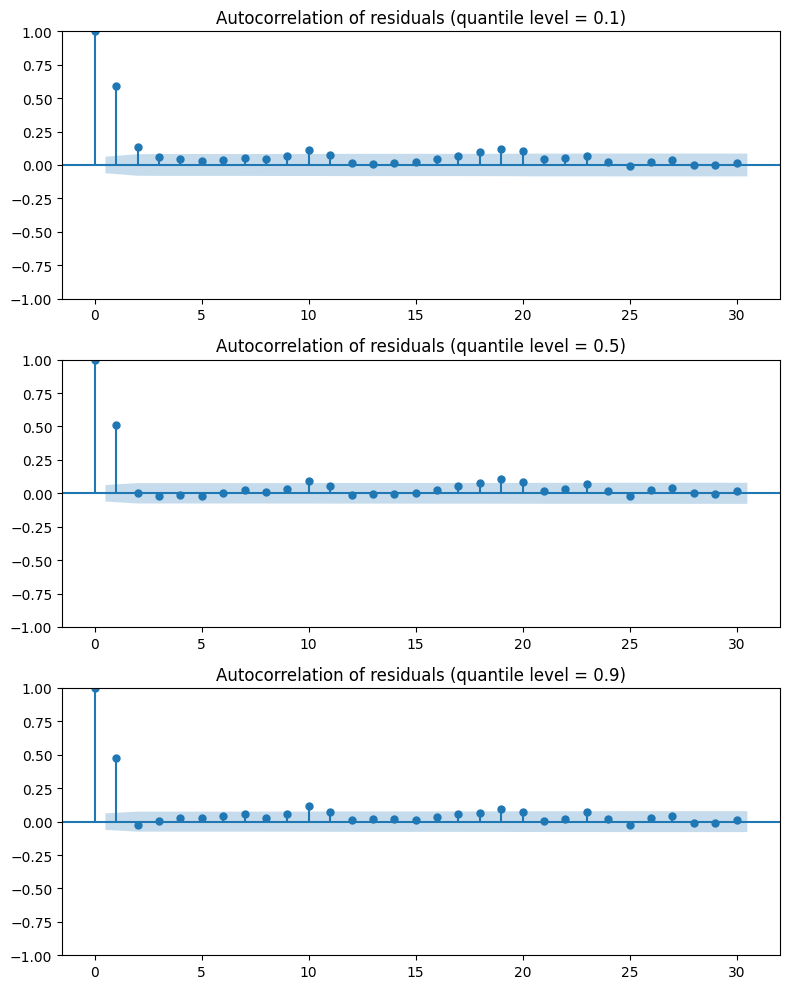

(<class 'statsmodels.iolib.summary.Summary'>
 """
                          QuantReg Regression Results                          
 Dep. Variable:                      y   Pseudo R-squared:               0.2429
 Model:                       QuantReg   Bandwidth:                       4.696
 Method:                 Least Squares   Sparsity:                        49.02
 Date:                Wed, 26 Apr 2023   No. Observations:                  999
 Time:                        19:35:36   Df Residuals:                      998
                                         Df Model:                            1
                  coef    std err          t      P>|t|      [0.025      0.975]
 ------------------------------------------------------------------------------
 x1             0.6666      0.010     65.717      0.000       0.647       0.686
 """,
 <class 'statsmodels.iolib.summary.Summary'>
 """
                          QuantReg Regression Results                          
 Dep. Variable

In [28]:
fit_quantile(new_df, 6, 0.3, 0.9)

In [6]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

def ols_gls_estimation(df, quantile=0.5, max_iter=100, tol=1e-6):
    # convert data to float64 data type
    df = df.astype('float64')
    
    # extract data
    x = df['x'].values
    y = df['y'].values
    epsilon_y = df['epsilon_y'].values
    T = len(y)
    
    # OLS estimation of the parameters
    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    epsilon_lag = np.roll(epsilon_y, 1)
    epsilon_lag[0] = 0
    X = np.column_stack((np.ones_like(x), y_lag, x, epsilon_lag))
    beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
    
    # GLS estimation of the parameters
    resid = y - X @ beta_hat
    acf_resid, ci = sm.tsa.stattools.acf(resid, nlags=10, alpha=0.05)
    sigma2 = np.var(resid) * (1 - acf_resid[1])
    sigma2_array = np.full(T, sigma2)
    rho = acf_resid[1] / (1 - acf_resid[1])
    S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
    beta_gls = np.linalg.inv(X.T @ np.linalg.inv(S) @ X) @ X.T @ np.linalg.inv(S) @ y
    
    # Quantile regression estimation of the parameters using EM algorithm
    beta = beta_gls.copy()
    beta_prev = beta_gls.copy()
    for i in range(max_iter):
        # E-step: calculate the weighted residuals using current estimates of the parameters
        u = y - X @ beta
        w = np.where(u >= 0, 1 - quantile, quantile)
        W = np.diag(w)
        
        # M-step: update the estimates of the parameters using weighted quantile regression
        y_q = y - u / w
        X_q = X / w[:, None]
        beta = np.linalg.inv(X_q.T @ X_q) @ X_q.T @ y_q
        
        # check convergence
        if np.max(np.abs(beta - beta_prev)) < tol:
            break
        else:
            beta_prev = beta.copy()
    
    print("GLS parameter estimates:")
    print("alpha_hat = {:.4f}".format(beta_gls[0]))
    print("beta_hat = {:.4f}".format(beta_gls[1]))
    print("gamma_hat = {:.4f}".format(beta_gls[2]))
    print("theta_hat = {:.4f}".format(beta_gls[3]))
    
    print("Quantile regression parameter estimates:")
    print("alpha_hat = {:.4f}".format(beta[0]))
    print("beta_hat = {:.4f}".format(beta[1]))
    print("gamma_hat = {:.4f}".format(beta[2]))
    print("theta_hat = {:.4f}".format(beta[3]))
    
    return beta


In [8]:
ols_gls_estimation(new_df)

GLS parameter estimates:
alpha_hat = 0.9153
beta_hat = 0.9007
gamma_hat = 0.9015
theta_hat = 0.5002
Quantile regression parameter estimates:
alpha_hat = -44.8516
beta_hat = -44.1338
gamma_hat = -44.1740
theta_hat = -24.5009


array([-44.85159131, -44.13375084, -44.17400676, -24.50094441])

In [9]:
def ols_gls_estimation(df):
    # convert data to float64 data type
    df = df.astype('float64')
    
    # extract data
    x = df['x'].values
    y = df['y'].values
    epsilon_y = df['epsilon_y'].values
    T = len(y)
    
    # OLS estimation of the parameters
    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    epsilon_lag = np.roll(epsilon_y, 1)
    epsilon_lag[0] = 0
    X = np.column_stack((np.ones_like(x), y_lag, x, epsilon_lag))
    beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
    print("OLS parameter estimates:")
    print("alpha_hat = {:.4f}".format(beta_hat[0]))
    print("beta_hat = {:.4f}".format(beta_hat[1]))
    print("gamma_hat = {:.4f}".format(beta_hat[2]))
    print("theta_hat = {:.4f}".format(beta_hat[3]))
    
    # GLS estimation of the parameters
    resid = y - X @ beta_hat
    acf_resid, ci = sm.tsa.stattools.acf(resid, nlags=10, alpha=0.05)
    sigma2 = np.var(resid) * (1 - acf_resid[1])
    sigma2_array = np.full(T, sigma2)
    rho = acf_resid[1] / (1 - acf_resid[1])
    S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
    beta_gls = np.linalg.inv(X.T @ np.linalg.inv(S) @ X) @ X.T @ np.linalg.inv(S) @ y
    print("GLS parameter estimates:")
    print("alpha_hat = {:.4f}".format(beta_gls[0]))
    print("beta_hat = {:.4f}".format(beta_gls[1]))
    print("gamma_hat = {:.4f}".format(beta_gls[2]))
    print("theta_hat = {:.4f}".format(beta_gls[3]))

    return y_lag, epsilon_lag

In [10]:
ols_gls_estimation(new_df)

OLS parameter estimates:
alpha_hat = 0.9153
beta_hat = 0.9007
gamma_hat = 0.9015
theta_hat = 0.5000
GLS parameter estimates:
alpha_hat = 0.9153
beta_hat = 0.9007
gamma_hat = 0.9015
theta_hat = 0.5002


(array([  0.        ,   9.76933787,  18.40954571,  26.20678513,
         33.51835764,  40.04537767,  45.87433776,  50.92965672,
         55.65983811,  60.31933895,  64.47388075,  67.80114819,
         70.82174478,  73.67476626,  76.05789679,  78.26385356,
         80.46392583,  82.26025673,  83.83937676,  85.33337365,
         86.81390583,  88.24062086,  89.35378649,  90.07390278,
         90.9851646 ,  91.7035223 ,  92.19199599,  92.5641543 ,
         92.85328277,  93.26570859,  93.73954783,  94.17918394,
         94.77816208,  95.31979901,  95.57959733,  95.8197442 ,
         96.18235539,  96.49889261,  96.90729498,  97.3594317 ,
         97.61554083,  97.81181877,  97.64497009,  97.50508527,
         97.38220418,  97.19439511,  97.18167673,  97.42325257,
         97.46595923,  97.54823261,  97.30732361,  97.04998051,
         97.01456015,  97.23495598,  97.46929049,  97.85217961,
         98.22500407,  98.64837266,  99.00266735,  99.18267966,
         99.24037954,  99.53256695,  99.

In [17]:
def ols_gls_estimation2(df):
    # convert data to float64 data type
    df = df.astype('float64')
    
    # extract data
    x = df['x'].values
    y = df['y'].values
    epsilon_y = df['epsilon_y'].values
    T = len(y)
    
    # OLS estimation of the parameters
    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    epsilon_lag = np.roll(epsilon_y, 1)
    epsilon_lag[0] = 0
    X = np.column_stack((np.ones_like(x), y_lag, x, epsilon_lag))
    beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
    
    # GLS estimation of the parameters
    resid = y - X @ beta_hat
    acf_resid, ci = sm.tsa.stattools.acf(resid, nlags=10, alpha=0.05)
    sigma2 = np.var(resid) * (1 - acf_resid[1])
    sigma2_array = np.full(T, sigma2)
    rho = acf_resid[1] / (1 - acf_resid[1])
    S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
    beta_gls = np.linalg.inv(X.T @ np.linalg.inv(S) @ X) @ X.T @ np.linalg.inv(S) @ y

    #return y_lag, epsilon_lag
#def quantile_loss(y_true, y_pred, tau):
    """
    Computes the quantile loss between y_true and y_pred for a given quantile tau.
    """

    tau = 0.1
    error = y - y_pred
    np.maximum(tau * error, (tau - 1) * error)

    n_iter=100
    """
    Fits a quantile regression model using the EM algorithm to minimize the quantile loss function.
    """
    # Initialize weights
    n_features = X.shape[3]
    weights = np.zeros(n_features)

    # Loop over iterations
    for i in range(n_iter):
        # E-step: compute weights that minimize the expected loss
        y_pred = np.dot(X, weights)
        error = y - y_pred
        weight_1 = np.where(y >= y_pred, tau, 0)
        weight_2 = np.where(y < y_pred, 1 - tau, 0)
        weights = np.linalg.lstsq(X * (weight_1 + weight_2)[:, np.newaxis], error * (weight_1 + weight_2))[0]

    return weights


In [18]:
ols_gls_estimation2(new_df)

UnboundLocalError: local variable 'y_pred' referenced before assignment

In [13]:
X = np.column_stack((np.ones_like(x), y_lag, x, epsilon_lag))
weights = fit_quantile_regression(X, y, 0.1)

NameError: name 'y_lag' is not defined

In [ ]:
''''  New'''

In [ ]:
def quantile_loss(y_true, y_pred, tau):
    """
    Computes the quantile loss between y_true and y_pred for a given quantile tau.
    """
    error = y_true - y_pred
    return np.maximum(tau * error, (tau - 1) * error)

def quantile_regression(X, y, tau, n_iter=100):
    """
    Fits a quantile regression model using the EM algorithm to minimize the quantile loss function.
    """
    # Initialize weights
    n_features = X.shape[1]
    weights = np.zeros(n_features)

    # Loop over iterations
    for i in range(n_iter):
        # E-step: compute weights that minimize the expected loss
        y_pred = np.dot(X, weights)
        error = y - y_pred
        weight_1 = np.where(y >= y_pred, tau, 0)
        weight_2 = np.where(y < y_pred, 1 - tau, 0)
        weights = np.linalg.lstsq(X * (weight_1 + weight_2)[:, np.newaxis], error * (weight_1 + weight_2))[0]

    return weights

def ols_gls_estimation2(df, tau):
    # convert data to float64 data type
    df = df.astype('float64')
    
    # extract data
    x = df['x'].values
    y = df['y'].values
    epsilon_y = df['epsilon_y'].values
    T = len(y)
    
    # quantile regression with GLS estimation of the parameters
    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    epsilon_lag = np.roll(epsilon_y, 1)
    epsilon_lag[0] = 0
    X = np.column_stack((np.ones_like(x), y_lag, x, epsilon_lag))
    weights = quantile_regression(X, y, tau)
    y_pred = np.dot(X, weights)
    resid = y - y_pred
    acf_resid
